In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from smoker_status.config import RAW_DATA_DIR
from smoker_status.features import setup_X
from smoker_status.util import count_missing_values, make_mi_scores, plot_mi_score

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

df = pd.read_csv(RAW_DATA_DIR / 'train.csv')

In [31]:
_X = df.drop(['id'], axis=1)
y = _X.pop('smoking')
X = setup_X(_X)
X

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,1,1,0,-2.0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708
159252,1.0,1.0,1,1,1,0,0.8,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127
159253,1.5,1.0,1,1,1,0,-2.0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997
159254,1.2,1.0,1,1,1,0,2.0,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         159256 non-null  int64  
 1   height(cm)                  159256 non-null  int64  
 2   weight(kg)                  159256 non-null  int64  
 3   waist(cm)                   159256 non-null  float64
 4   eyesight(left)              159256 non-null  float64
 5   eyesight(right)             159256 non-null  float64
 6   systolic                    159256 non-null  int64  
 7   relaxation                  159256 non-null  int64  
 8   fasting blood sugar         159256 non-null  int64  
 9   Cholesterol                 159256 non-null  int64  
 10  triglyceride                159256 non-null  int64  
 11  HDL                         159256 non-null  int64  
 12  LDL                         159256 non-null  int64  
 13  hemoglobin    

In [17]:
X.describe()

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05
mean,0.997593,0.993716,1.023974,1.023421,1.074233,0.197996,0.285549,0.044381,1.252844,1.031220,0.509149,1.153765,1.456755,0.464108,0.126871,0.309734,0.264354,1.395816,2.052695,2.248666e-17,9.160414e-16,-4.986774e-16,-2.951820e-16,4.933680e-16,-6.715659e-16,6.000904e-15,4.500901e-16,-8.888477e-16,1.270675e-16,9.669263e-16,2.104466e-15,3.631774e-16,-1.444645e-15,5.267411e-16,7.238563e-16,-1.359907e-16,-3.198103e-16
std,0.311283,0.310485,0.152969,0.151238,0.347856,0.398490,1.676109,0.258191,0.610643,0.856905,0.595055,1.019599,1.132330,0.724135,0.332830,0.462385,0.440990,0.563515,1.008344,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.052535e+00,-3.432036e+00,-2.951152e+00,-3.572484e+00,-3.574724e+00,-3.654862e+00,-5.510102e+00,-4.183425e+00,-4.802244e+00,-3.355225e+00,-1.699684e+01,-6.915110e+00,-5.732268e+00,-4.500298e+00,-5.259910e+00,-3.834845e+00,-3.993230e+00,-3.780182e+00
25%,0.800000,0.800000,1.000000,1.000000,1.000000,0.000000,-2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-3.636662e-01,-5.972291e-01,-5.675808e-01,-6.700213e-01,-6.680387e-01,-7.642430e-01,-5.824399e-01,-7.323400e-01,-6.985435e-01,-7.771848e-01,-6.685891e-01,-6.965898e-01,-4.881627e-01,-6.604680e-01,-7.598293e-01,-7.740312e-01,-7.365560e-01,-6.621671e-01
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-3.636662e-01,-3.026766e-02,-1.703190e-01,-2.221364e-04,-1.181252e-01,1.251782e-01,-1.062286e-01,7.178092e-03,5.565612e-02,-1.326748e-01,9.309188e-02,1.418624e-01,8.756874e-02,-5.107434e-02,-1.242002e-01,-1.310249e-01,-3.735805e-02,-6.868401e-02
75%,1.200000,1.200000,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.000000,3.000000,9.029851e-01,5.366938e-01,6.242046e-01,6.695770e-01,5.889064e-01,5.698888e-01,4.134519e-01,7.466962e-01,7.367245e-01,5.834474e-01,7.380377e-01,7.008306e-01,6.337622e-01,5.861693e-01,6.349302e-01,6.557377e-01,6.468512e-01,5.065869e-01
max,2.000000,2.000000,2.000000,2.000000,6.000000,1.000000,2.000000,3.000000,2.000000,4.000000,2.000000,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000,5.000000,3.436288e+00,2.804539e+00,4.994084e+00,4.911638e+00,7.109309e+00,6.239949e+00,9.998601e+00,6.944562e+00,3.645155e+00,5.739527e+00,1.183540e+01,4.334123e+00,1.868942e+01,1.196927e+01,1.005772e+01,5.798077e+00,1.693364e+01,6.332767e+00


In [19]:
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

BMI                   0.141278
sex                   0.114240
triglyceride          0.075996
AST/ALT               0.041904
triglyceride class    0.036670
age                   0.025866
systolic              0.013154
BMI class             0.010894
Cholesterol           0.008400
FPG class             0.004357
ALT class             0.003749
creatinine class      0.000848
Urine protein         0.000551
Name: MI Scores, dtype: float64

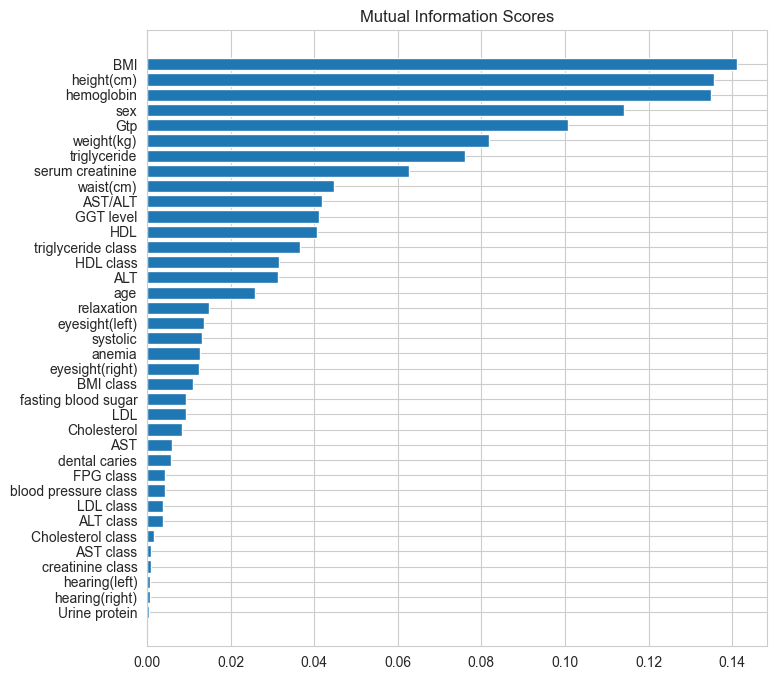

In [22]:
plt.figure(dpi=100, figsize=(8, 8))
plot_mi_score(mi_scores)

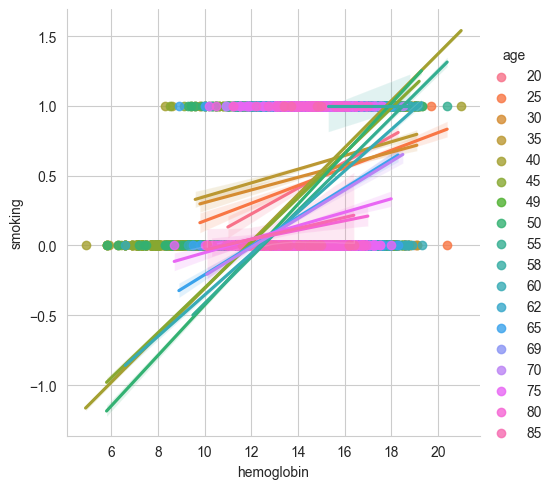

In [23]:
sns.lmplot(x='hemoglobin', y='smoking', hue='age', data=df)

Try out some clustering

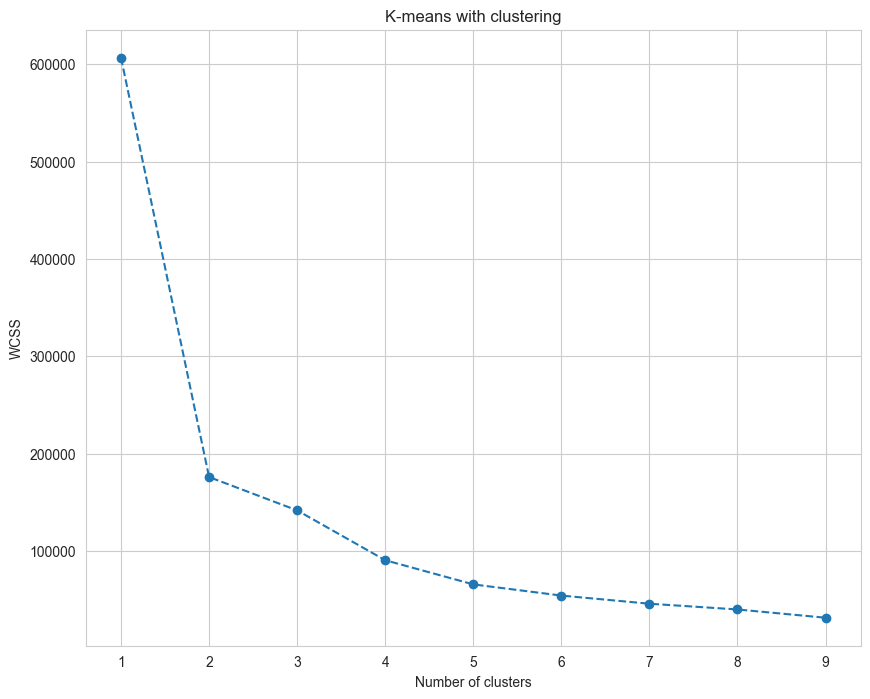

In [98]:
def f(feature_cols):
    wcss = []
    for i in range (1, 10):
        X_copy = X.copy(deep=True)
        _X = X_copy[feature_cols]

        # Clustering
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(_X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 10), wcss, marker = 'o', linestyle = '--')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('K-means with clustering')
    plt.show()

# f(['BMI', 'waist(cm)'])
# f(['height(cm)', 'weight(kg)'])
# f(['hemoglobin', 'Gtp'])
f(['sex', 'BMI'])

In [208]:
def try_clustering(feature_cols, n_clusters = 4, plot = False):
    X_copy = X.copy(deep=True)
    _X = X_copy[feature_cols]

    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    X_copy['Cluster'] = kmeans.fit_predict(_X)
    X_copy['Cluster'] = X_copy['Cluster'].astype('category')

    if plot:
        sns.relplot(x=feature_cols[0], y=feature_cols[1], hue='Cluster', data=X_copy, height=6)
    return X_copy

In [ ]:
try_clustering(['height(cm)', 'weight(kg)'])

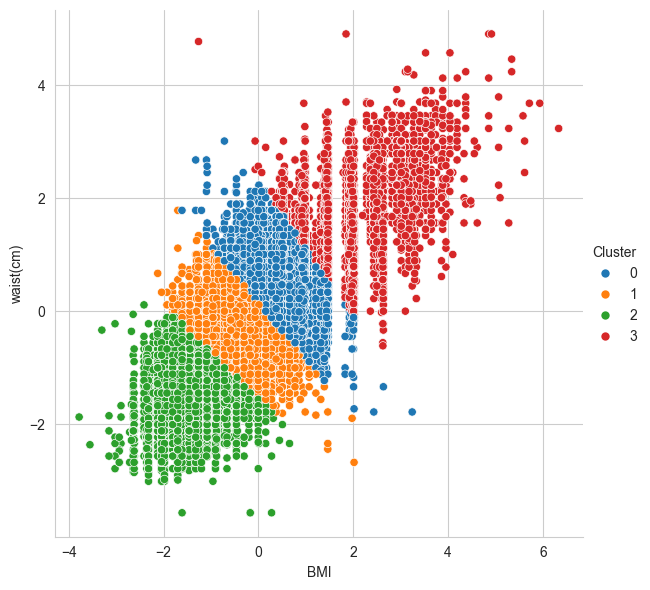

In [56]:
_X = try_clustering(['BMI', 'waist(cm)'])

In [288]:
from itertools import combinations

n = 4

feats_to_try = [
    # 'BMI',
    # 'height(cm)',
    # 'hemoglobin',
    # 'Gtp',
    # 'weight(kg)',
    # 'triglyceride',
    # 'serum creatinine',
    # 'waist(cm)',
    # 'AST/ALT',
    'HDL',
    # 'ALT',
    # 'age',
    # 'relaxation',
    # 'systolic',
    # 'fasting blood sugar',
    'LDL',
    'Cholesterol',
    # 'AST',
]

d = {}
for t in combinations(feats_to_try, 2):
    print(t)
    _X = try_clustering([t[0], t[1]], n_clusters=n)
    _X['smoking'] = _X.index.map(y)
    scores = []
    for i in range(n):
        _df = _X[_X['Cluster'] == i]
        # cor = _df.corr()
        # cor_target = abs(cor['smoking'])
        # # print(cor_target)
        # relevant_features = cor_target[cor_target > 0.1]
        # _X_test = _df[relevant_features.index.to_list()]
        _y = _df.pop('smoking')
        clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
        # clf = LogisticRegression(n_jobs=-1)
        cv_scores = cross_val_score(clf, _df, _y, cv=2, scoring='roc_auc', n_jobs=-1)
        print(cv_scores.mean())
        scores.append(cv_scores.mean())
    _val = 0
    for s in scores:
        _val += s
    d[t] = (_val / len(scores))
    print(f'average: {d[t]}')
    print('---------')


('HDL', 'LDL')
0.8122257834589748
0.8739718782978942
0.8029445747323632
0.9071114254526991
average: 0.8490634154854828
---------
('HDL', 'Cholesterol')
0.8229176997965831
0.7923348317242228
0.9175662134321836
0.8677534949028229
average: 0.8501430599639532
---------
('LDL', 'Cholesterol')
0.8829842524185523
0.8406303167959297
0.8417008530255501
0.8306072049300133
average: 0.8489806567925113
---------


In [278]:
sorted(d.values())

[np.float64(0.8430104468841639),
 np.float64(0.8444407004129674),
 np.float64(0.8460294877778984),
 np.float64(0.8465210113320708),
 np.float64(0.846764758788825),
 np.float64(0.8479191724917198),
 np.float64(0.8480266868445557),
 np.float64(0.8483129063448704),
 np.float64(0.8483870726400009),
 np.float64(0.8489806567925113),
 np.float64(0.8490634154854828),
 np.float64(0.8493164073383037),
 np.float64(0.8501430599639532),
 np.float64(0.8507197108111586),
 np.float64(0.8534118556766137)]

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,Cluster
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686,1
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497,0
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907,1
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142,1
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,1,1,0,-2.0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708,2
159252,1.0,1.0,1,1,1,0,0.8,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127,2
159253,1.5,1.0,1,1,1,0,-2.0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997,2
159254,1.2,1.0,1,1,1,0,2.0,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882,1


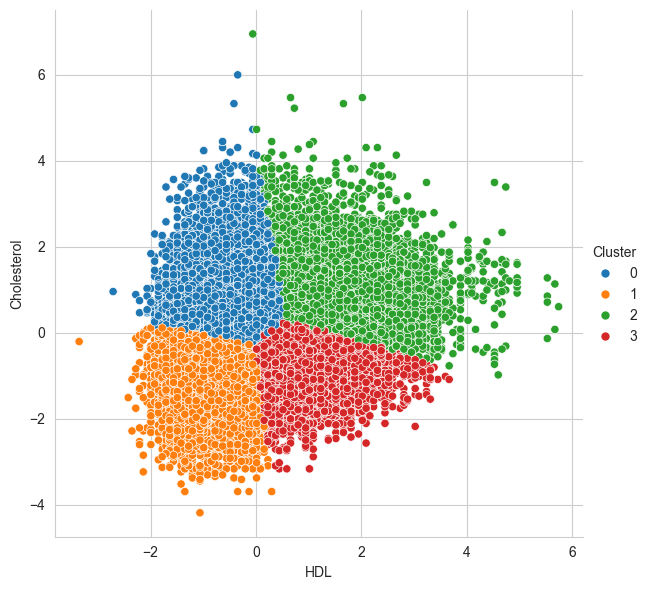

In [177]:
try_clustering(['HDL', 'Cholesterol'])

In [287]:
n = 4
_X = try_clustering(['HDL', 'LDL'], n_clusters=n)
_X['smoking'] = _X.index.map(y)
fpr_list = []
tpr_list = []
for i in range(n):
    _df = _X[_X['Cluster'] == i]
    _df.drop(['Cluster'], axis=1)
    _y = _df.pop('smoking')
    clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
    cv_scores = cross_val_score(clf, _df, _y, cv=2, scoring='accuracy', n_jobs=-1)
    print(cv_scores.mean())
    X_train, X_test, y_train, y_test = train_test_split(
        _df, _y, test_size=0.3, random_state=1
    )
    print(X_train.shape)
    print(X_test.shape)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    # print(y_predict)
    y_predict_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(AUC)
    fpr_list.append(fpr)
    tpr_list.append(tpr)


0.7363748146540812
(38711, 38)
(16591, 38)
0.813131952303644
0.7962188612099644
(15736, 38)
(6744, 38)
0.8704150072545016
0.7401148625169431
(33760, 38)
(14469, 38)
0.8018000609543228
0.847796691777168
(23271, 38)
(9974, 38)
0.9074597922118488


In [223]:
print(len(fpr_list[0]))
print(len(fpr_list[1]))
print(len(fpr_list[2]))
print(len(fpr_list[3]))

77
97
79
89


,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,Cluster
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686,1
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497,1
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907,1
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142,3
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,1,1,0,-2.0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708,0
159252,1.0,1.0,1,1,1,0,0.8,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127,0
159253,1.5,1.0,1,1,1,0,-2.0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997,2
159254,1.2,1.0,1,1,1,0,2.0,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882,1


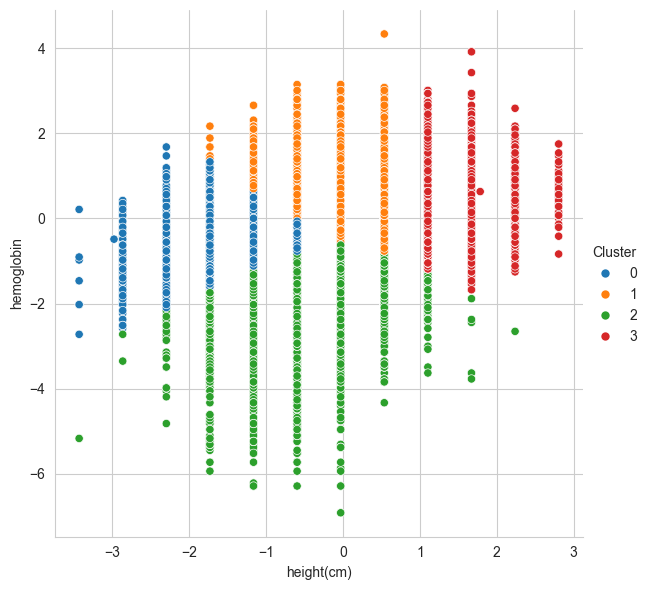

In [212]:
try_clustering(['height(cm)', 'hemoglobin'], n_clusters=n, plot=True)

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,Cluster
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686,0
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497,0
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907,1
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142,0
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,1,1,0,-2.0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708,2
159252,1.0,1.0,1,1,1,0,0.8,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127,2
159253,1.5,1.0,1,1,1,0,-2.0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997,1
159254,1.2,1.0,1,1,1,0,2.0,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882,2


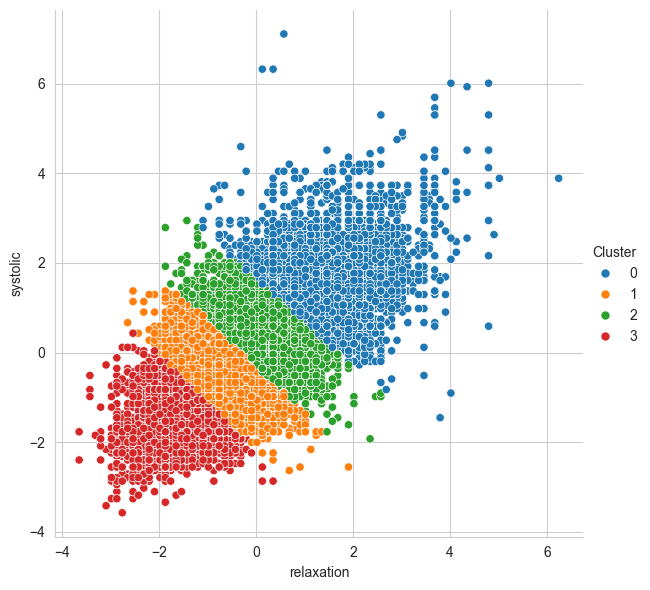

In [283]:
try_clustering(['relaxation', 'systolic'], n_clusters=n, plot=True)

In [262]:
X_copy = X.copy(deep=True)
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
scores = cross_val_score(clf, X_copy, y, cv=10, scoring='roc_auc', n_jobs=-1)
scores.mean()

np.float64(0.855932231852133)

In [290]:
from smoker_status.util import plot_within_cluster_sum_squares, try_clustering, cluster_and_classify

clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

X_copy = X.copy(deep=True)
X_copy['smoking'] = X_copy.index.map(y)
res = cluster_and_classify(X_copy, ['relaxation', 'systolic'], 4, clf)

([np.float64(0.7579139055468842),
  np.float64(0.7728487478043601),
  np.float64(0.7587051695171996),
  np.float64(0.8194632683658171)],
 [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         2.05718988e-04, 4.11437976e-04, 6.17156964e-04, 1.02859494e-03,
         1.85147089e-03, 2.67434684e-03, 3.49722279e-03, 5.34869368e-03,
         6.78872660e-03, 8.43447850e-03, 1.02859494e-02, 1.25488583e-02,
         1.54289241e-02, 1.78975519e-02, 2.09833368e-02, 2.42748406e-02,
         2.79777823e-02, 3.33264760e-02, 3.86751697e-02, 4.32009875e-02,
         5.10183090e-02, 5.84241926e-02, 6.45957622e-02, 7.30302407e-02,
         8.00246863e-02, 8.66076939e-02, 9.44250154e-02, 1.01419461e-01,
         1.09442502e-01, 1.18082699e-01, 1.25900021e-01, 1.38243160e-01,
         1.48734828e-01, 1.58403621e-01, 1.68895289e-01, 1.78975519e-01,
         1.89261469e-01, 1.98724542e-01, 2.07981897e-01, 2.19913598e-01,
         2.31639580e-01, 2.42542687e-01, 2.54885826e-01, 2.6

In [276]:
X_copy = X.copy(deep=True)
clf = LogisticRegression(n_jobs=-1)
scores = cross_val_score(clf, X_copy, y, cv=10, scoring='roc_auc', n_jobs=-1)
scores.mean()

np.float64(0.8421271538124616)

In [253]:
X_copy = X.copy(deep=True)
pca = PCA()
pca.fit(X_copy)

PCA()

In [254]:
pca.explained_variance_ratio_

array([3.17477820e-01, 1.20892505e-01, 8.74669178e-02, 7.93686367e-02,
       6.04035346e-02, 5.35280155e-02, 4.13886703e-02, 3.72975231e-02,
       3.25698142e-02, 2.68037496e-02, 2.37593093e-02, 2.19086410e-02,
       1.65514863e-02, 9.12065285e-03, 8.68047669e-03, 6.37847655e-03,
       5.67865286e-03, 5.38648208e-03, 4.89980595e-03, 4.75172014e-03,
       4.40791711e-03, 3.57367522e-03, 3.47251278e-03, 3.18361780e-03,
       2.93811110e-03, 2.86030542e-03, 2.69543798e-03, 2.63308573e-03,
       2.43680480e-03, 2.25026633e-03, 1.66668016e-03, 1.20532031e-03,
       1.02505580e-03, 6.83858723e-04, 3.74853101e-04, 1.70646520e-04,
       1.08960757e-04])

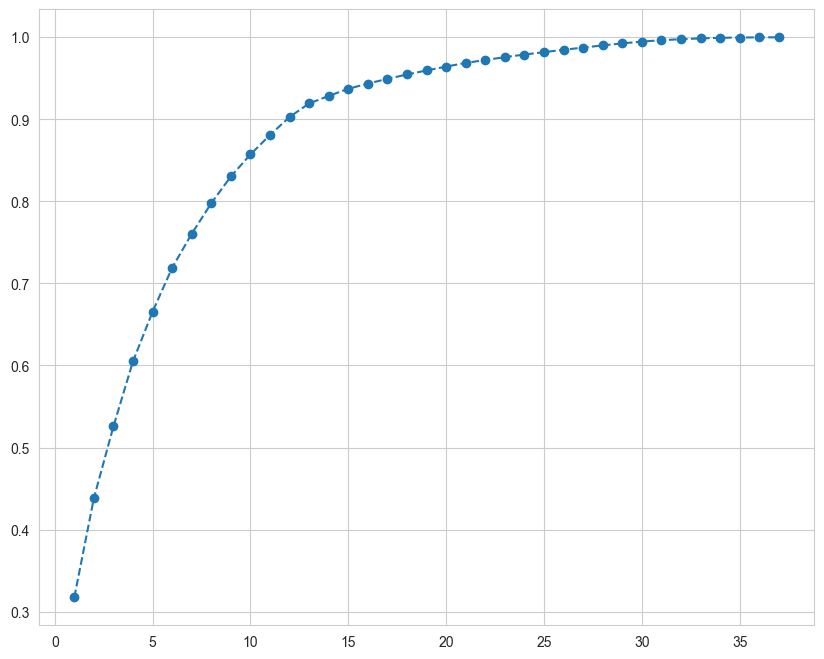

In [255]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

Rule of thumb is to keep 80% of variance. So we keep 8 components

In [256]:
pca = PCA(n_components=8)
pca.fit(X_copy)
_X_pca = pca.transform(X_copy)

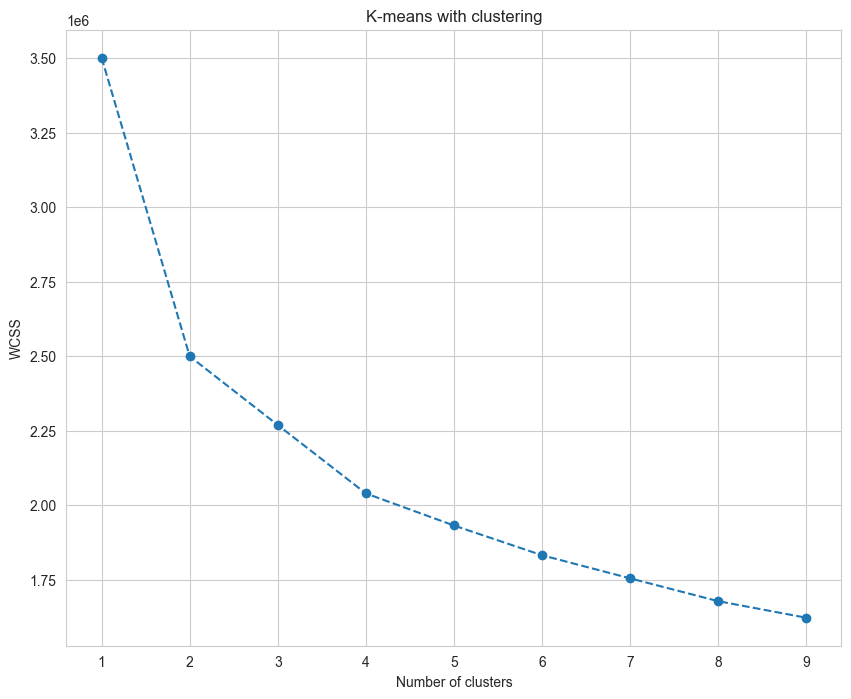

In [257]:
wcss = []
for i in range (1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(_X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with clustering')
plt.show()

In [258]:
kmeans_pca = KMeans(n_clusters=4, random_state=0)
kmeans_pca.fit(_X_pca)
X_pca_kmeans = pd.concat([X_copy.reset_index(drop=True), pd.DataFrame(_X_pca)], axis=1)
X_pca_kmeans.columns.values[-8:] = [
    'Component 1',
    'Component 2',
    'Component 3',
    'Component 4',
    'Component 5',
    'Component 6',
    'Component 7',
    'Component 8',
]
X_pca_kmeans['Cluster'] = kmeans_pca.labels_

In [263]:
X_pca_kmeans['smoking'] = X_pca_kmeans.index.map(y)
for i in range(n):
    _temp = X_pca_kmeans[X_pca_kmeans['Cluster'] == i]
    _temp.drop(['Cluster'], axis=1)
    # cor = _temp.corr()
    # cor_target = abs(cor['smoking'])
    # # print(cor_target)
    # relevant_features = cor_target[cor_target > 0.1]
    # _X_test = _temp[relevant_features.index.to_list()]
    _y = _temp.pop('smoking')
    clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
    scores = cross_val_score(clf, _temp, _y, cv=5, scoring='roc_auc', n_jobs=-1)
    print(scores.mean())

0.8978894008036825
0.8934384815660017
0.7090173662607443
0.7333337703738827


In [136]:
X_copy

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,1,1,0,-2.0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708
159252,1.0,1.0,1,1,1,0,0.8,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127
159253,1.5,1.0,1,1,1,0,-2.0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997
159254,1.2,1.0,1,1,1,0,2.0,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882


In [139]:
X_pca_kmeans = pd.concat([X_copy.reset_index(drop=True), pd.DataFrame(_X_pca)], axis=1)
X_pca_kmeans.columns.values[-8:] = [
    'Component 1',
    'Component 2',
    'Component 3',
    'Component 4',
    'Component 5',
    'Component 6',
    'Component 7',
    'Component 8',
]
X_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [140]:
X_pca_kmeans.head()

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment K-means PCA
0,0.5,0.6,1,1,1,0,1.0,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686,0.909109,-1.078687,2.210455,0.411830,-0.725782,2.371842,-1.453108,1.304730,3
1,0.6,0.7,2,2,1,1,2.0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497,1.726178,1.030931,2.200942,-0.552187,-0.641350,0.906769,3.888111,1.133158,2
2,0.4,0.5,1,1,1,0,2.0,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907,2.578167,-2.055376,-0.860681,1.727598,-0.125699,0.048517,-1.776400,-1.325319,2
3,1.5,1.2,1,1,1,1,2.0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142,4.608839,-1.557556,0.835650,-1.586195,0.716724,0.287284,-1.760430,-0.182819,2
4,1.5,1.0,1,1,1,0,-2.0,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686,-2.706082,-1.672693,1.035282,0.239485,-0.005205,0.611890,-1.433725,-0.239138,1


In [149]:
X_pca_kmeans.describe()

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Segment K-means PCA
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,159256.000000
mean,0.997593,0.993716,1.023974,1.023421,1.074233,0.197996,0.285549,0.044381,1.252844,1.031220,0.509149,1.153765,1.456755,0.464108,0.126871,0.309734,0.264354,1.395816,2.052695,2.248666e-17,9.160414e-16,-4.986774e-16,-2.951820e-16,4.933680e-16,-6.715659e-16,6.000904e-15,4.500901e-16,-8.888477e-16,1.270675e-16,9.669263e-16,2.104466e-15,3.631774e-16,-1.444645e-15,5.267411e-16,7.238563e-16,-1.359907e-16,-3.198103e-16,4.390252e-17,-5.496739e-17,-1.135041e-16,1.910920e-16,2.231712e-16,-6.032136e-17,5.014882e-17,5.817977e-17,1.626978
std,0.311283,0.310485,0.152969,0.151238,0.347856,0.398490,1.676109,0.258191,0.610643,0.856905,0.595055,1.019599,1.132330,0.724135,0.332830,0.462385,0.440990,0.563515,1.008344,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,2.957785e+00,1.825196e+00,1.552501e+00,1.478885e+00,1.290152e+00,1.214508e+00,1.067949e+00,1.013794e+00,1.086120
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.052535e+00,-3.432036e+00,-2.951152e+00,-3.572484e+00,-3.574724e+00,-3.654862e+00,-5.510102e+00,-4.183425e+00,-4.802244e+00,-3.355225e+00,-1.699684e+01,-6.915110e+00,-5.732268e+00,-4.500298e+00,-5.259910e+00,-3.834845e+00,-3.993230e+00,-3.780182e+00,-9.173282e+00,-7.099269e+00,-7.376253e+00,-5.769024e+00,-5.382925e+00,-6.831556e+00,-4.978945e+00,-4.252982e+00,0.000000
25%,0.800000,0.800000,1.000000,1.000000,1.000000,0.000000,-2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-3.636662e-01,-5.972291e-01,-5.675808e-01,-6.700213e-01,-6.680387e-01,-7.642430e-01,-5.824399e-01,-7.323400e-01,-6.985435e-01,-7.771848e-01,-6.685891e-01,-6.965898e-01,-4.881627e-01,-6.604680e-01,-7.598293e-01,-7.740312e-01,-7.365560e-01,-6.621671e-01,-2.304671e+00,-1.218751e+00,-1.079947e+00,-1.028282e+00,-8.780368e-01,-8.211392e-01,-7.152592e-01,-6.866856e-01,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-3.636662e-01,-3.026766e-02,-1.703190e-01,-2.221364e-04,-1.181252e-01,1.251782e-01,-1.062286e-01,7.178092e-03,5.565612e-02,-1.326748e-01,9.309188e-02,1.418624e-01,8.756874e-02,-5.107434e-02,-1.242002e-01,-1.310249e-01,-3.735805e-02,-6.868401e-02,2.878500e-01,2.062182e-02,-4.823928e-02,-7.057445e-02,-2.530501e-02,-1.335761e-02,-6.406490e-02,-2.642320e-02,2.000000
75%,1.200000,1.200000,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.00

<Figure size 1000x800 with 0 Axes>

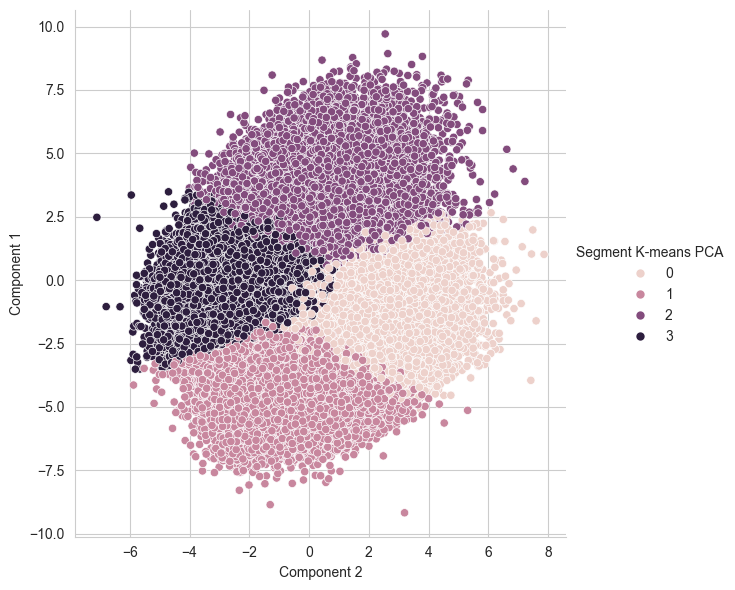

In [151]:
plt.figure(figsize=(10, 8))
sns.relplot(x='Component 2', y='Component 1', hue='Segment K-means PCA', data=X_pca_kmeans, height=6)
plt.show()